In [1]:
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
data_dir = "//dhc/groups/adni_transformer/t1_128_int/"

In [4]:
data = os.listdir(data_dir)


In [5]:
data[0]

'4171303_2.npy.npz'

In [27]:
def load_image(filename):
        data_from_file = np.load(os.path.join(data_dir, filename))
        return data_from_file['arr_0']

In [28]:
def __getitem__(index):
        filename = data[index]
        img = load_image(filename)
        img = torch.tensor(load_image(filename))
        img = (img - img.min()) / (img.max() - img.min()) # normalize
        img = img[None, ...]  # add channel dim
        
        return img

In [29]:
a = __getitem__(8)

In [30]:
a.shape

torch.Size([1, 128, 128, 128])

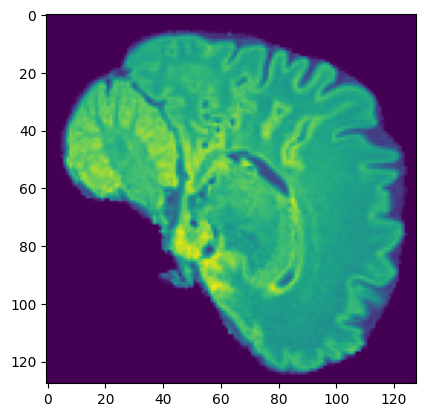

In [32]:
plt.imshow(a[0, 50, :, :])

In [33]:
pd.DataFrame({'filename': [1,2,3], 'location': 42})

,filename,location
0,1,42
1,2,42
2,3,42


In [41]:
class PretrainADNIDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, meta_file_path, train_fraction, validation_fraction, test_fraction, transform=None, split='train'):
        super().__init__()
        
        self.data_dir = data_dir
        self.meta_file_path = meta_file_path
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.test_fraction = test_fraction        
        # self.transform = get_pretrain_tfms() #transform
        self.split = split
        self.ukbb_path1 = "//dhc/groups/adni_transformer/t1_128_int/"
        self.ukbb_path2 = "//dhc/groups/adni_transformer/t1_128_int/"
        self.files = pd.DataFrame(columns=['filename', 'location'])

        self.classes = ['AD', 'CN', 'MCI', 'EMCI', 'LMCI', 'SMC'] #remove AD for anomaly detection
        self.adni_meta_file = pd.read_csv(self.meta_file_path) # first of all load metadata
        print(self.files.shape)
        self.load_adni_files()
        print(self.files.shape)
        self.load_ukbb_files()
        print(self.files.shape)
        
        
    def __len__(self):
        return len(self.files['filename'])
    
    def __getitem__(self, index):
        filename, location = self.files.iloc[index][['filename', 'location']]
        
        img = torch.tensor(self.load_image(filename, location))
        img = (img - img.min()) / (img.max() - img.min()) # normalize
        img = img[None, ...]  # add channel dim
        
        if self.transform:
            return self.transform(img)
        else:
            return img

    def load_image(self, filename, location):
        data_from_file = np.load(os.path.join(location, filename))
        return data_from_file['arr_0']
    
    def perform_split(self):
        np.random.seed(42)
        patients = self.adni_meta_file['PTID'].unique()
        patients = np.random.permutation(patients)
        
        if self.split == 'train':
            patients = patients[:int(patients.shape[0] * self.train_fraction)]
        elif self.split == 'val':
            patients = patients[int(patients.shape[0] * self.train_fraction):int(patients.shape[0] * (self.train_fraction + self.validation_fraction))]
        elif self.split == 'test':
            patients = patients[int(patients.shape[0] * (self.train_fraction + self.validation_fraction)):] # leave test_fraction cause unnecessary
        else:
            raise ValueError('split must be one of train, val, test')
            
        self.adni_meta_file = self.adni_meta_file[self.adni_meta_file.PTID.isin(patients)]
    
    def load_adni_files(self):
        adni_files = pd.DataFrame({'filename': os.listdir(self.data_dir), 'location': self.data_dir})
        adni_files['image_uid'] = adni_files['filename'].apply(lambda name: name.split('.')[0].split('_')[-1])
        self.adni_meta_file = self.adni_meta_file[self.adni_meta_file['IMAGEUID'].isin(adni_files['image_uid'])]
        self.adni_meta_file = self.adni_meta_file[self.adni_meta_file['DX'].isin(self.classes)]
        self.perform_split()
        adni_files = adni_files[adni_files['image_uid'].isin(self.adni_meta_file['IMAGEUID'])]
        #self.files = self.files.append(adni_files[['filename', 'location']])
        self.files = pd.concat([self.files, adni_files], join='inner')


    def load_ukbb_files(self):
        ukbb1_files = pd.DataFrame({'filename': os.listdir(self.data_dir), 'location': self.ukbb_path1})
        ukbb2_files = pd.DataFrame({'filename': os.listdir(self.data_dir), 'location': self.ukbb_path2})
       # self.files = self.files.append(ukbb1_files[['filename', 'location']])
        #self.files = self.files.append(ukbb2_files[['filename', 'location']])
        self.files = pd.concat([self.files, ukbb1_files], join='inner')
        self.files = pd.concat([self.files, ukbb2_files], join='inner')

In [42]:
data = PretrainADNIDataset(
    data_dir = "/dhc/groups/adni_transformer/adni_128_int/",
    meta_file_path = "/dhc/groups/adni_transformer/adni_metadata/df_procAlex_MMSE.csv",
    train_fraction=1.0,
    validation_fraction=0.0,
    test_fraction=0.0)

(0, 2)
(12785, 2)
(38375, 2)
